The data is scraped from airlinequality.com by quankiquanki: https://github.com/quankiquanki/skytrax-reviews-dataset 

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

In [105]:
df=pd.read_csv('skytrax-reviews-dataset-master/data/airline.csv')

In [106]:
df.head(2)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1


In [107]:
len(df[df.aircraft.isnull()])

40118

# Data exploration

In [108]:
df.describe()

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,36861.000000,33706.000000,33708.000000,33264.000000,31114.000000,2203.000000,565.000000,39723.000000,41396.000000
mean,6.039527,3.094612,3.319212,2.805886,2.392364,2.736723,2.249558,3.164111,0.533820
std,3.214680,1.405515,1.541307,1.580246,1.704753,1.569073,1.541283,1.523486,0.498861
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


* From this descriptive table, we see that we only have problem with missing values, but there is no outliers. Note that for some features, we see the min of rating is 0, which is invalid (from 1 to 5) so those are also missing values. To deal with missing values, I will record them as (-1), because the missing values may reveal something about the data. This will be done in the data wrangling part. For ground service rating, because we only have 2,203 rates for this over 41,396 observations, we will not use this feature in our model.

In [109]:
df.dtypes

airline_name                      object
link                              object
title                             object
author                            object
author_country                    object
date                              object
content                           object
aircraft                          object
type_traveller                    object
cabin_flown                       object
route                             object
overall_rating                   float64
seat_comfort_rating              float64
cabin_staff_rating               float64
food_beverages_rating            float64
inflight_entertainment_rating    float64
ground_service_rating            float64
wifi_connectivity_rating         float64
value_money_rating               float64
recommended                        int64
dtype: object

In [110]:
len(df['airline_name'].unique()) #how many airlines operate

362

In [111]:
len(df['author_country'].unique()) #to see whether the reviews come from just some countries

159

In [112]:
df['type_traveller'].unique() #which types of travellers 

array([nan, 'FamilyLeisure', 'Couple Leisure', 'Solo Leisure', 'Business'], dtype=object)

In [113]:
df['cabin_flown'].unique() #types of cabins

array(['Economy', 'Business Class', nan, 'Premium Economy', 'First Class'], dtype=object)

In [114]:
len(df['aircraft'].unique()) #how many types of aircraft

364

In [115]:
len(df['route'].unique()) #how many routes

2209

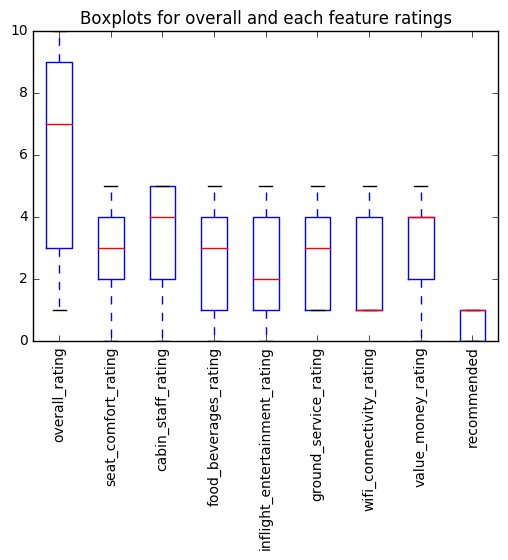

In [116]:
df.plot.box()
plt.xticks(rotation='vertical')
plt.title('Boxplots for overall and each feature ratings')
plt.show()

This box plot shows that while most feature ratings are in average of 3 to 4 on 5 star scale, the ratings for inflight entertainment and especially wifi connectivity are very low. From this finding, we may guess there is more correlation between these 2 features with overall rating (we will verify this with further analysis). Also, most airlines are recommended (value=1) and most travellers also give high rates for value-money. 

# Data wrangling

In [117]:
#get rid of data points without overall rating
df_clean=df[df['overall_rating'].notnull()]

In [118]:
#'link','title','author','author_country','date','content','aircraft','route'
df_clean.drop(['link','title','author','author_country','date','content','aircraft','route'],axis=1, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [119]:
df_clean.head()

,airline_name,type_traveller,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,NaN,Economy,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,NaN,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,adria-airways,NaN,Economy,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1
3,adria-airways,NaN,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,NaN,4.0,1
4,adria-airways,NaN,Economy,4.0,4.0,2.0,1.0,2.0,NaN,NaN,2.0,0


In [120]:
#fill missing values of rating type with (-1) because missing values may still be meaningful, 
#so keep it with new value out of range can help to understand their impact better
df_clean=df_clean.fillna({'seat_comfort_rating':-1, 'cabin_staff_rating':-1, 'food_beverages_rating':-1, 'inflight_entertainment_rating':-1, 'ground_service_rating':-1, 'wifi_connectivity_rating':-1, 'value_money_rating':-1}, inplace=True)

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [121]:
#replace missing value of categorical variables with their mode
df_clean=df_clean.fillna(df_clean.mode().iloc[0])


In [122]:
df_clean.isnull().values.any() #check if there are any missing values in dataframe

False

In [123]:
#change types of columns traveller types, recommended and cabin flown into category type
df_clean['type_traveller']=df_clean.type_traveller.astype('category')
df_clean['recommended']=df_clean['recommended'].astype('category')
df_clean['cabin_flown']=df_clean['cabin_flown'].astype('category')


# Modelling

#### Simple linear regression

In [145]:
m = ols('overall_rating ~ type_traveller+cabin_flown+seat_comfort_rating + cabin_staff_rating+food_beverages_rating+inflight_entertainment_rating+value_money_rating+ground_service_rating+recommended+wifi_connectivity_rating',df_clean).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     9663.
Date:                Tue, 18 Oct 2016   Prob (F-statistic):               0.00
Time:                        21:27:54   Log-Likelihood:                -66936.
No. Observations:               36861   AIC:                         1.339e+05
Df Residuals:                   36846   BIC:                         1.340e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

R-squared=78.6% means that the model fits well with the data. Look at p_value, we find that all except for travellers as couple or family leisure, first class in cabin flown and wifi connectivity are statistically significant.

In [135]:
df_clean.cabin_flown.unique()

[Economy, Business Class, Premium Economy, First Class]
Categories (4, object): [Economy, Business Class, Premium Economy, First Class]

#### Ridge regression

In [124]:
y=df_clean.overall_rating

In [125]:
X=df_clean.drop(['overall_rating','airline_name'], axis=1)

In [156]:
#tranform string label in categorical variables into numeric values
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
for i in range(10):
    X.iloc[:,i] = le.fit_transform(X.iloc[:,i])

In [157]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=1)

In [158]:
ln=LinearRegression()
ln.fit(Xlr,ylr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [171]:
pd.DataFrame(list(zip(Xlr.columns, ln.coef_)), columns =['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,type_traveller,0.271123
1,cabin_flown,-0.044726
2,seat_comfort_rating,-0.033082
3,cabin_staff_rating,0.051545
4,food_beverages_rating,0.037401
5,inflight_entertainment_rating,-0.016446
6,ground_service_rating,0.043314
7,wifi_connectivity_rating,0.022425
8,value_money_rating,0.531027
9,recommended,4.264732


In [174]:
RSS=sum((ln.predict(Xtestlr)-ytestlr)**2)
R_squared=ln.score(Xtestlr,ytestlr)
print('sum squared error: ',RSS)
print('R squared: ', R_squared)

sum squared error:  20168.8226685
R squared:  0.790243897203


In [172]:
from sklearn.linear_model import Ridge
ridge_model=Ridge(alpha=1.0)
ridge_model.fit(Xlr,ylr)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [175]:
RSS_ridge=sum((ridge_model.predict(Xtestlr)-ytestlr)**2)
R_squared_ridge=ridge_model.score(Xtestlr,ytestlr)
print('sum squared error: ',RSS_ridge)
print('R squared: ', R_squared_ridge)

sum squared error:  20169.0152183
R squared:  0.790241894682
